In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
token_path = "/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/kaggle/input/flickr8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'


doc = open(token_path,'r').read()
print(doc[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [3]:
# Make a dictionary having key(image id) and value(list of caption related to that image)
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[1:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

In [11]:
len(descriptions)

8092

In [4]:
def func(id):
    res = []
    for i in descriptions[id]:
        res.append(i.lower().split())
    return res

In [5]:
# We create a vocabulary of all the unique words present across all the 8000*5 image captions in the dataset.
#We have 9630 unique words across all the 40000 image captions.
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 9630


In [6]:
#save the image id’s and their new cleaned captions in the same format as the token.txt file
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
        
new_descriptions = '\n'.join(lines)

In [7]:
# take the ids of training image from Flickr_8k.trainImages.txt file
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
        identifier= line.split('.')[0]
        dataset.append(identifier)

train = set(dataset)

In [8]:
#here we seperate train and test images
img = glob.glob(images_path + '/*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i.split('/')[6] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []

for i in img:
    
    if i.split('/')[6] in test_images: 
        test_img.append(i)

In [10]:
len(train_img)

6000

In [12]:
len(test_img)

1000

In [9]:
#addtwo tokens in every caption of training images, which are ‘startseq’ and ‘endseq’
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)


In [10]:
#Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [11]:
#reduce our vocabulary to only those words which repeat at least 10 times in the entire corpus, to make
#model more robust
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1698


In [12]:
#create two dictionaries to map words to an index and vice versa
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


In [13]:
#gettng maximum length of caption
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 40


In [14]:
# load the model and remove last layer, we need to only extract image vector for our image.
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 0s 0us/step


In [15]:
#process the image before feeding to model
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [16]:
#encode our training and testing images
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img] = encode(img)


1/1 [==============================] - 0s 27ms/step


In [23]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Attention, Concatenate,add
from tensorflow.keras.models import Model

# Image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)  #,return_sequences=True

# Attention mechanism (Bahdanau Attention)
attn = Attention()([fe2, se3])
context_vector = add([fe2, attn])

# Decoder model
decoder1 = LSTM(256)(context_vector)
# decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


# Complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 40, 256)      434944      ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [24]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch, vocab_size):
    X1, X2, y = [], [], []
    n = 0
    # loop forever over images
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            # retrieve the photo feature
            photo = photos[images_path + '/' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = [], [], []
                n = 0

In [25]:
#freeze trainable parameter of model
model.layers[2].trainable = False

In [26]:
#compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
epochs = 10
batch_size = 12
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size,vocab_size)
print(generator)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

<generator object data_generator at 0x7eac64462110>
Epoch 1/10
500/500 [==============================] - 63s 115ms/step - loss: 4.2849
Epoch 2/10
500/500 [==============================] - 57s 114ms/step - loss: 3.4774
Epoch 3/10
500/500 [==============================] - 57s 114ms/step - loss: 3.2155
Epoch 4/10
500/500 [==============================] - 56s 112ms/step - loss: 3.0648
Epoch 5/10
500/500 [==============================] - 57s 113ms/step - loss: 2.9544
Epoch 6/10
500/500 [==============================] - 57s 114ms/step - loss: 2.8668
Epoch 7/10
500/500 [==============================] - 57s 113ms/step - loss: 2.7965
Epoch 8/10
500/500 [==============================] - 57s 114ms/step - loss: 2.7335
Epoch 9/10
500/500 [==============================] - 57s 113ms/step - loss: 2.6812
Epoch 10/10
500/500 [==============================] - 57s 114ms/step - loss: 2.6347


In [29]:
# save the model
model.save('Model8k.h5')

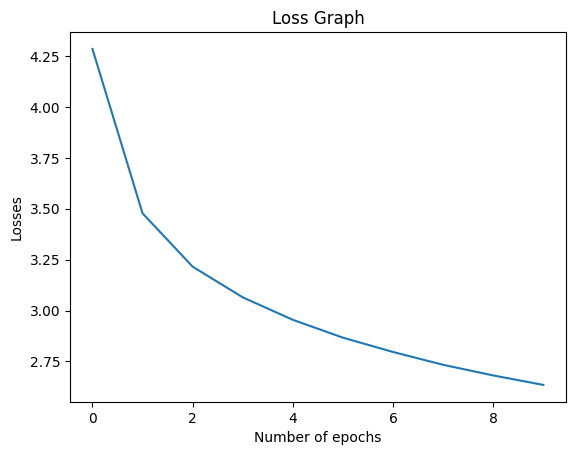

In [30]:
#Plot loss graph
loss_values = history.history['loss']
epochs = list(range(len(loss_values)))
plt.plot(epochs, loss_values)
plt.title("Loss Graph")
plt.xlabel("Number of epochs")
plt.ylabel("Losses")
plt.show()

In [31]:
# done with training, that will give a long vector with a probability distribution across all the words in the vocabulary.
#pick the word with the highest probability to get the next word prediction
def testing(photo):
    
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [32]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4ac0d55648ba45df4a96a461881bfc171925709413ea198f69672e43a38e9ba7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [33]:
from rouge_score import rouge_scorer

In [34]:
def get_list_of_caption(id):
    res = ''
    for val in descriptions[id]:
        res += val.lower()
        res += ','
    return res

In [35]:
def get_weight_list(n):
    weights = [1.0 / n] * n 
    return weights

In [36]:
#validating captions
# validate with test data

bl_score = []
b1_score = []
b2_score = []
b3_score = []
precision = []
recall = []
fmeasure = []
roug_score = {}


for key in test_img:
    key_id = key.split('/')[6][:-4]
    # get actual caption
    captions = descriptions[key_id]
    
    # predict the caption for image
    y_pred = testing(encoding_test[key].reshape((1,2048)))
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred_l = y_pred.split()
    
    bleu_scores = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(4)) #bydefault
    bleu_scores1 = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(1))
    bleu_scores2 = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(2))
    bleu_scores3 = sentence_bleu(actual_captions, y_pred_l,weights=get_weight_list(3))
    bl_score.append(bleu_scores)
    b1_score.append(bleu_scores1)
    b2_score.append(bleu_scores2)
    b3_score.append(bleu_scores3)
    
    reference_captions = get_list_of_caption(image_id)
    scorer = rouge_scorer.RougeScorer(['rouge1'])
    roug_scores = scorer.score(reference_captions, y_pred)
    
    precision.append(roug_scores['rouge1'].precision)
    recall.append(roug_scores['rouge1'].recall)
    fmeasure.append(roug_scores['rouge1'].fmeasure)

  
    


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [37]:
# calcuate BLEU score
length = len(bl_score)
score = sum(bl_score)/length
score1 = sum(b1_score)/length
score2 = sum(b2_score)/length
score3 = sum(b3_score)/length

print(f"BLEU-sore1 : {score1}")
print(f"BLEU-sore2 : {score2}")
print(f"BLEU-sore3 : {score3}")
print(f"BLEU-sore4 : {score}")

precision_avg = sum(precision)/length
recall_avg = sum(recall)/length
fmeasure_avg = sum(fmeasure)/length
roug_score['precision'] = precision_avg
roug_score['recall'] = recall_avg
roug_score['fmeasure'] = fmeasure_avg
print(f"roug score : {roug_score}")

BLEU-sore1 : 0.5978398045673162
BLEU-sore2 : 0.44781780379296504
BLEU-sore3 : 0.45771609314994416
BLEU-sore4 : 0.5065026915322133
roug score : {'precision': 0.5826104600765599, 'recall': 0.12060000000000003, 'fmeasure': 0.19790113016758076}


/kaggle/input/flickr8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/2228022180_9597b2a458.jpg
2228022180_9597b2a458
a group of children are playing on a stage .


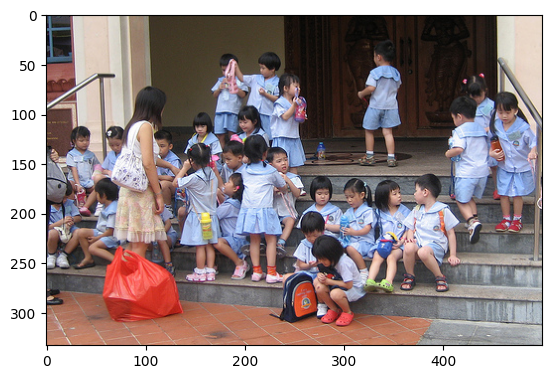

Predicted Caption: A group of children are playing on a stage .
BLEU Score1: 0.7
BLEU Score2: 0.3944053188733077
BLEU Score3: 0.268904774337424
BLEU Score4: 0.37342112655242105
rouge1: Score(precision=0.7777777777777778, recall=0.14285714285714285, fmeasure=0.24137931034482757)


In [38]:
# pred_data = {}
# ori_data = {}
pic = list(encoding_test.keys())[18]
print(pic)

image_id = pic.split('/')[6].split('.')[0]
print(image_id)
# pred_data[image_id] = [testing(image)]
# ori_data[image_id] = descriptions[image_id]
image = encoding_test[pic].reshape((1,2048))



# Sample generated and reference captions
generated_captions = testing(image).lower()
print(generated_captions)
reference_captions = get_list_of_caption(image_id)


# Tokenize captions
tokenized_gen_captions = generated_captions.split()

# tokenized_ref_captions = reference_captions.split()
tokenized_ref_captions = func(image_id)

# Calculate BLEU scores
bleu_scores1 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(1))
bleu_scores2 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(2))
bleu_scores3 = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions,weights=get_weight_list(3))
bleu_scores = sentence_bleu(tokenized_ref_captions, tokenized_gen_captions)

x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Predicted Caption:",testing(image))
print(f"BLEU Score1: {bleu_scores1}")
print(f"BLEU Score2: {bleu_scores2}")
print(f"BLEU Score3: {bleu_scores3}")
print(f"BLEU Score4: {bleu_scores}")

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1'])
roug_scores = scorer.score(reference_captions, generated_captions)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')




In [ ]:
# initialise pretrained model
model = InceptionV3(weights='imagenet')
model = Model(model.input, model.layers[-2].output)

# Summerize
print(model.summary())

In [ ]:
#process the image before feeding to model
def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
# extract features from image
features = {}

for img_name in os.listdir(image_path):
    # load the image from file
    img_path = image_path + '/' + img_name
    image = preprocess(img_path)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
doc = open(caption_path,'r').read()[33:]
print(doc[:500])

In [ ]:
# Make a dictionary having key(image id) and value(list of caption related to that image)
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split(',')
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]
            image_desc = ' '.join(tokens[1:])
            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

In [ ]:
#clean captions
def clean(mapping):
    for id, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() 
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# We create a vocabulary of all the unique words present across all the image captions in the dataset.

vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

In [ ]:
#Create a list of all the training captions
all_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_captions.append(cap)

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def idx_to_word(integer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

In [ ]:
# spliting image ids for training and testing model
image_ids = list(descriptions.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, vocab_size, batch_size):
    # loop over images
    X1 = []
    X2 = []
    y = [] 
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1 = []
                X2 = []
                y = [] 
                n = 0

In [ ]:
#We are creating a Merge model where we combine the image vector and the caption.
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

In [ ]:
#freeze trainable parameter of model
model.layers[2].trainable = False

In [ ]:
#compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# train the model
epochs = 10
batch_size = 16

steps = len(train) // batch_size

# for i in range(epochs):
    # create data generator
generator = data_generator(train, descriptions, features, vocab_size, batch_size)
    # fit for one epoch
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
    
    

In [ ]:
#Plot loss graph

loss_values = history.history['loss']
epochs = list(range(len(loss_values)))
plt.plot(epochs, loss_values)
plt.title("Loss Graph")
plt.xlabel("Number of epochs")
plt.ylabel("Losses")
plt.show()

In [ ]:
# done with training, that will give a long vector with a probability distribution across all the words in the vocabulary.

def testing(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat)
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
pip install rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
def get_list_of_caption(id):
    res = ''
    for val in descriptions[id]:
        res += val.lower()
        res += ','
    return res

In [ ]:
def get_weight_list(n):
    weights = [1.0 / n] * n 
    return weights

In [ ]:
#validating captions
from nltk.translate.bleu_score import sentence_bleu
# validate with test data
actual, predicted = list(), list()
# with open("mappedData.txt","w+") as f:
for key in test:
    # get actual caption
    captions = descriptions[key]
    # predict the caption for image
    y_pred = testing(features[key])
        
        #write key,caption and pedicted caption in a file
#         f.write(key+"\t" + captions + "\t" + y_pred)
#         f.write('\n')
        
    ref_cap = get_list_of_caption(key)
    gen_cap = y_pred.lower()

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred_token = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
blue_score1 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(1))
blue_score2 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(2))
blue_score3 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(3))
blue_score4 = sentence_bleu(actual_captions, y_pred_token)

scorer = rouge_scorer.RougeScorer(['rouge1'])
roug_scores = scorer.score(ref_cap, gen_cap)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')


In [ ]:
print("Blue score of 1gram : ", blue_score1)
print("Blue score of 2gram : ", blue_score2)
print("Blue score of 3gram : ", blue_score3)
print("Blue score of 4gram : ", blue_score4)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_path, image_name)
    image = Image.open(img_path)
    captions = descriptions[image_id]
    
    for caption in captions:
        print("Actual caption {}", caption)
    # predict the caption
    y_pred = testing(features[image_id])
 
    print("Predicted caption {}", y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1000919630.jpg")

In [ ]:
generate_caption("100207720.jpg")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
img = '/kaggle/input/flickr30k/flickr30k_images/1000919630.jpg'
x=plt.imread(img)
key = img.split('/')[5].split('.')[0]

captions = descriptions[key]
# predict the caption for image
y_pred = testing(features[key])

ref_cap = get_list_of_caption(key)
gen_cap = y_pred.lower()
# split into words
actual_captions = [caption.split() for caption in captions]
y_pred_token = y_pred.split()
blue_score1 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(1))
blue_score2 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(2))
blue_score3 = sentence_bleu(actual_captions, y_pred_token,weights=get_weight_list(3))
blue_score4 = sentence_bleu(actual_captions, y_pred_token)
print("Blue score of 1gram : ", blue_score1)
print("Blue score of 2gram : ", blue_score2)
print("Blue score of 3gram : ", blue_score3)
print("Blue score of 4gram : ", blue_score4)


scorer = rouge_scorer.RougeScorer(['rouge1'])
roug_scores = scorer.score(ref_cap, gen_cap)
for key in roug_scores:
    print(f'{key}: {roug_scores[key]}')
    
# plt.imshow(x)
# plt.show()

In [ ]:
# Đọc file các caption
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r', encoding = 'utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/kaggle/input/flickr30k/captions.txt"

doc = load_doc(filename)
print(doc[:450])

In [ ]:
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split(",")
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[2:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

In [ ]:
descriptions['1029450589']

In [ ]:
# Preprocessing text
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['1029450589']

In [ ]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w', encoding='utf-8')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions_english.txt')

In [ ]:
lines1 = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines1.append(key+".jpg")
data1 = '\n'.join(lines1[:len(lines1)*9//10])
data2 = '\n'.join(lines1[len(lines1)*9//10:])
file1 = open("image_train.txt", 'w', encoding='utf-8')
file2 = open("image_test.txt", 'w', encoding='utf-8')
file1.write(data1)
file2.write(data2)
file1.close()
file2.close()

In [ ]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load dataset (6K)
filename = 'image_train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

In [ ]:
# Folder chứa dữ liệu ảnh
images = '/kaggle/input/flickr30k/flickr30k_images/'
# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')
print(len(img))

In [ ]:
# File chứa các id ảnh để train
train_images_file = 'image_train.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
print(len(train_img))

In [ ]:
# File chứa các id ảnh để test
test_images_file = "image_test.txt"
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions_english.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

In [ ]:
# Load ảnh, resize về khích thước mà Inception v3 yêu cầu.
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
train_features = load(open("/kaggle/input/feature-vector/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

In [ ]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

In [ ]:
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

In [ ]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            if key+".jpg" not in photos:
                continue
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:

# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, '/kaggle/input/feature-vector/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
"""
import fasttext
embeddings_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
print('Found %s word vectors.' % len(embeddings_index.words))
"""

In [ ]:
embeddings_index['the']

In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

In [ ]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
model.save_weights('/kaggle/working/weights.h5')

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model1 = Model(inputs=[inputs1, inputs2], outputs=outputs)

model1.layers[2].set_weights([embedding_matrix])
model1.layers[2].trainable = False

model1.compile(loss='categorical_crossentropy', optimizer='adam')

model1.load_weights('weights.h5')


In [ ]:
images = '/kaggle/input/flickr30k/flickr30k_images/'

In [ ]:
with open("/kaggle/input/feature-vector/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model1.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
z=6
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))

In [ ]:
 for z in range(200):   
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print(greedySearch(image))